In [1]:
import rdkit2ase
import plumed_nodes as pn

In [2]:
na_plus = rdkit2ase.smiles2conformers("[Na+]", numConfs=1)
cl_minus = rdkit2ase.smiles2conformers("[Cl-]", numConfs=1)
water = rdkit2ase.smiles2conformers("O", numConfs=1)
box = rdkit2ase.pack(
    [na_plus, cl_minus, water], counts=[1, 1, 10], density=700, packmol="packmol.jl"
)

cn_g2_0: COM ATOMS=3
cn_g2_1: COM ATOMS=6
cn_g2_2: COM ATOMS=9
cn_g2_3: COM ATOMS=12
cn_g2_4: COM ATOMS=15
cn_g2_5: COM ATOMS=18
cn_g2_6: COM ATOMS=21
cn_g2_7: COM ATOMS=24
cn_g2_8: COM ATOMS=27
cn_g2_9: COM ATOMS=30
cn_g2_group: GROUP ATOMS=cn_g2_0,cn_g2_1,cn_g2_2,cn_g2_3,cn_g2_4,cn_g2_5,cn_g2_6,cn_g2_7,cn_g2_8,cn_g2_9
cn: COORDINATION GROUPA=1 GROUPB=cn_g2_group R_0=0.3 NN=6 D_0=0.0


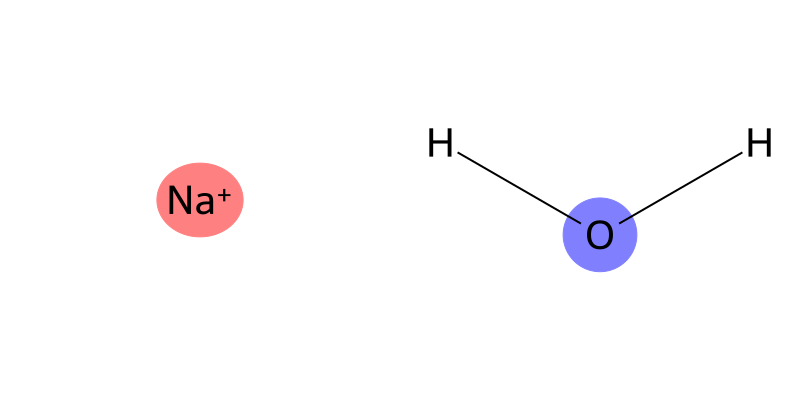

In [3]:
x1_selector = pn.SMILESSelector(smiles="[Na+]")
x2_selector = pn.SMARTSSelector(pattern="[O]")

coordination_cv = pn.CoordinationNumberCV(
    x1=x1_selector,
    x2=x2_selector,
    prefix="cn",
    r_0=0.3,
    d_0=0.0,
    group_reduction_1="first",
    group_reduction_2="com_per_group",
    multi_group="first",
)
for line in coordination_cv.to_plumed(box)[1]:
    print(line)
coordination_cv.get_img(box)

# define groups
# needs example of e.g. one Na in many water for a test

In [4]:
methylacetate = rdkit2ase.smiles2conformers(smiles="COC(=O)C", numConfs=50)
water = rdkit2ase.smiles2conformers(smiles="O", numConfs=50)
naoh = rdkit2ase.smiles2conformers(smiles="[OH-].[Na+]", numConfs=50)


box = rdkit2ase.pack(
    data=[methylacetate, naoh, water], counts=[1, 1, 16], density=1000, packmol="packmol.jl"
)

In [5]:
s1 = pn.SMARTSSelector(pattern="C[O:1]C(=O)C", hydrogens="exclude")
s2 = pn.SMARTSSelector(pattern="CO[C:1](=O)C", hydrogens="exclude")
# s3 = pn.SMARTSSelector(pattern="[OH2:1]", hydrogens="exclude")
# one or two hydrogens but no oxygen
s3 = pn.SMARTSSelector(pattern="[O;H1,H2;!$(O-C)]", hydrogens="exclude")

cn_g2_0: COM ATOMS=3
cn_g2_group: GROUP ATOMS=cn_g2_0
cn: COORDINATION GROUPA=2 GROUPB=cn_g2_group R_0=0.3 NN=6 D_0=0.0


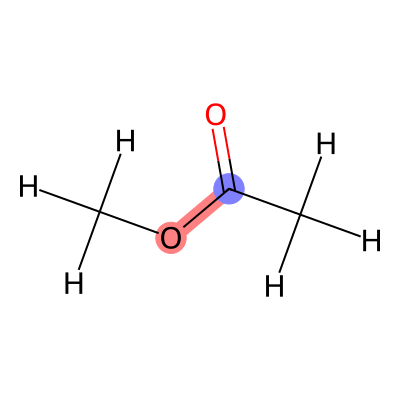

In [6]:
cv = pn.CoordinationNumberCV(
    x1=s1,
    x2=s2,
    prefix="cn",
    r_0=0.3,
    d_0=0.0,
    group_reduction_1="first",
    group_reduction_2="com_per_group",
    multi_group="first",
)
for line in cv.to_plumed(box)[1]:
    print(line)
cv.get_img(box)

cn: COORDINATION GROUPA=3 GROUPB=12,15,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60 R_0=0.3 NN=6 D_0=0.0


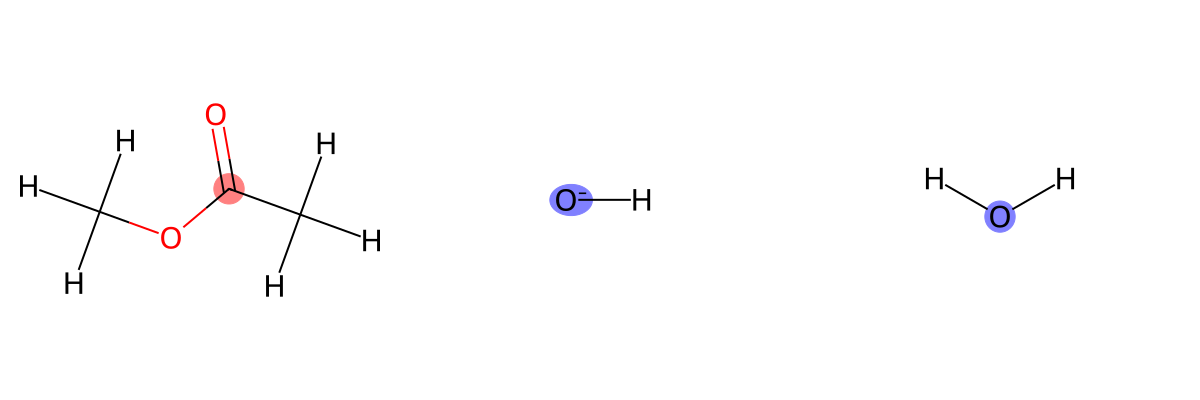

In [7]:
cv = pn.CoordinationNumberCV(
    x1=s2,
    x2=s3,
    prefix="cn",
    r_0=0.3,
    d_0=0.0,
    group_reduction_1="first",
    group_reduction_2="all",
    multi_group="first",
)
for line in cv.to_plumed(box)[1]:
    print(line)
cv.get_img(box)

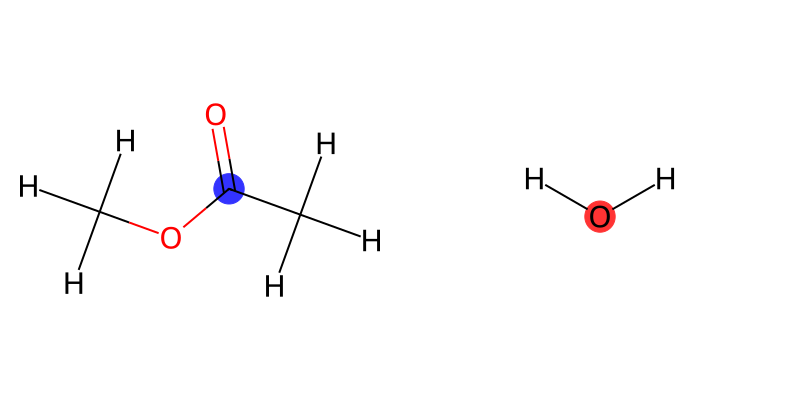

In [ ]:
import plumed_nodes as pn
import ipsuite as ips


data = ips.AddData("seed.xyz")
cv1 = pn.DistanceCV(
    x1=pn.SMARTSSelector(pattern="[H]O[H]"),
    x2=pn.SMARTSSelector(pattern="CO[C:1]"),
    prefix="d",
)
metad_cv1 = pn.MetaDBiasCV(
    cv=cv1, sigma=0.1, grid_min=0.0, grid_max=2.0, grid_bin=200
)
model = pn.MetaDynamicsModel(
    config=pn.MetaDynamicsConfig(height=1, pace=400, biasfactor=5),
    bias_cvs=[metad_cv1],
    data=data.frames,
    model=ips.MACEMP()
)
md = ips.ASEMD(
    model=model, data=data.frames, ...
)